In [1]:
### This note book is an R notebook for BCL-2 analysis
# First load packages
rm(list = ls())
setwd("./figure6/")
library(ggplot2)
library(trackViewer)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'trackViewer' was built under R version 3.6.1"Loading required package: GenomicRanges
Warning message:
"package 'GenomicRanges' was built under R version 3.6.1"Loading required package: stats4
Loading required package: BiocGenerics
Warning message:
"package 'BiocGenerics' was built under R version 3.6.1"Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame,

In [16]:
dir.fig.out = '../../manuscript/figures'

In [3]:
# 1. ------
# Set sequence position information for the domains and exons
BH4 = c(28,90); BH3 = c(277,321); BH1 = c(406,465);BH2 = c(559,606)
exon1 = c(60985315, 60985899)

In [4]:
# 2. -----
# Read BCL-2 mutation file(already parsed for synonymous muts)
df.bcl2.syn = read.csv('./data/df_bcl2_syn.csv', sep = ',')
# Read Bcl2 sequence (from GRCh37, what was used to calculate coverage)
# This is the coding sequence
bcl2.seq = 'ATGGCGCACGCTGGGAGAACAGGGTACGATAACCGGGAGATAGTGATGAAGTACATCCATTATAAGCTGTCGCAGAGGGGCTACGAGTGGGATGCGGGAGATGTGGGCGCCGCGCCCCCGGGGGCCGCCCCCGCACCGGGCATCTTCTCCTCCCAGCCCGGGCACACGCCCCATCCAGCCGCATCCCGGGACCCGGTCGCCAGGACCTCGCCGCTGCAGACCCCGGCTGCCCCCGGCGCCGCCGCGGGGCCTGCGCTCAGCCCGGTGCCACCTGTGGTCCACCTGACCCTCCGCCAGGCCGGCGACGACTTCTCCCGCCGCTACCGCCGCGACTTCGCCGAGATGTCCAGCCAGCTGCACCTGACGCCCTTCACCGCGCGGGGACGCTTTGCCACGGTGGTGGAGGAGCTCTTCAGGGACGGGGTGAACTGGGGGAGGATTGTGGCCTTCTTTGAGTTCGGTGGGGTCATGTGTGTGGAGAGCGTCAACCGGGAGATGTCGCCCCTGGTGGACAACATCGCCCTGTGGATGACTGAGTACCTGAACCGGCACCTGCACACCTGGATCCAGGATAACGGAGGCTGGGATGCCTTTGTGGAACTGTACGGCCCCAGCATGCGGCCTCTGTTTGATTTCTCCTGGCTGTCTCTGAAGACTCTGCTCAGTTTGGCCCTGGTGGGAGCTTGCATCACCCTGGGTGCCTATCTGGGCCACAAG'
bcl2.seq <- strsplit(bcl2.seq, split=NULL)[[1]]
print('Finish reading BCL-2 sequence')

[1] "Finish reading BCL-2 sequence"


In [5]:
# 3. For mutation number
#------
# An arrary with length bcl2 sequence filled with 0
arr.bcl2 = replicate(length(bcl2.seq), 0)
# Go through the bcl2 synonymous mutations and update arrary
for(i in (1:nrow(df.bcl2.syn))){
  pos = df.bcl2.syn$Start_position[i]
  mut_pos = exon1[2] - pos +1
  arr.bcl2[mut_pos] = arr.bcl2[mut_pos] + 1
}
print('Finish reading BCL-2 mutation')

[1] "Finish reading BCL-2 mutation"


In [6]:
# Steal the function rand_vect from stackoverflow...
# https://stackoverflow.com/questions/24845909/generate-n-random-integers-that-sum-to-m-in-r
rand_vect <- function(N, M, sd = 1, pos.only = TRUE) {
  vec <- rnorm(N, M/N, sd)
  if (abs(sum(vec)) < 0.01) vec <- vec + 1
  vec <- round(vec / sum(vec) * M)
  deviation <- M - sum(vec)
  for (. in seq_len(abs(deviation))) {
    vec[i] <- vec[i <- sample(N, 1)] + sign(deviation)
  }
  if (pos.only) while (any(vec < 0)) {
    negs <- vec < 0
    pos  <- vec > 0
    vec[negs][i] <- vec[negs][i <- sample(sum(negs), 1)] + 1
    vec[pos][i]  <- vec[pos ][i <- sample(sum(pos ), 1)] - 1
  }
  vec
}

In [7]:
print('Start sampling BCL-2 mutations')
# Sampling the BCL-2 mutations for 10000 times
set.seed(600)
par(mfrow = c(2,2))
sampled.arr.nmut = t(replicate(10000,rand_vect(717, 41, pos.only = TRUE)))
print('Finish sampling BCL-2 mutations')

[1] "Start sampling BCL-2 mutations"
[1] "Finish sampling BCL-2 mutations"


In [8]:
# Calculate permutation p-values
bh4.per.nmut = rowSums(sampled.arr.nmut[,BH4[1]:BH4[2]])
bh4.obs.nmut = sum(arr.bcl2[BH4[1]:BH4[2]])
bh4.exceed = length(bh4.per.nmut[bh4.per.nmut>= bh4.obs.nmut])
bh4.pval = bh4.exceed/10000

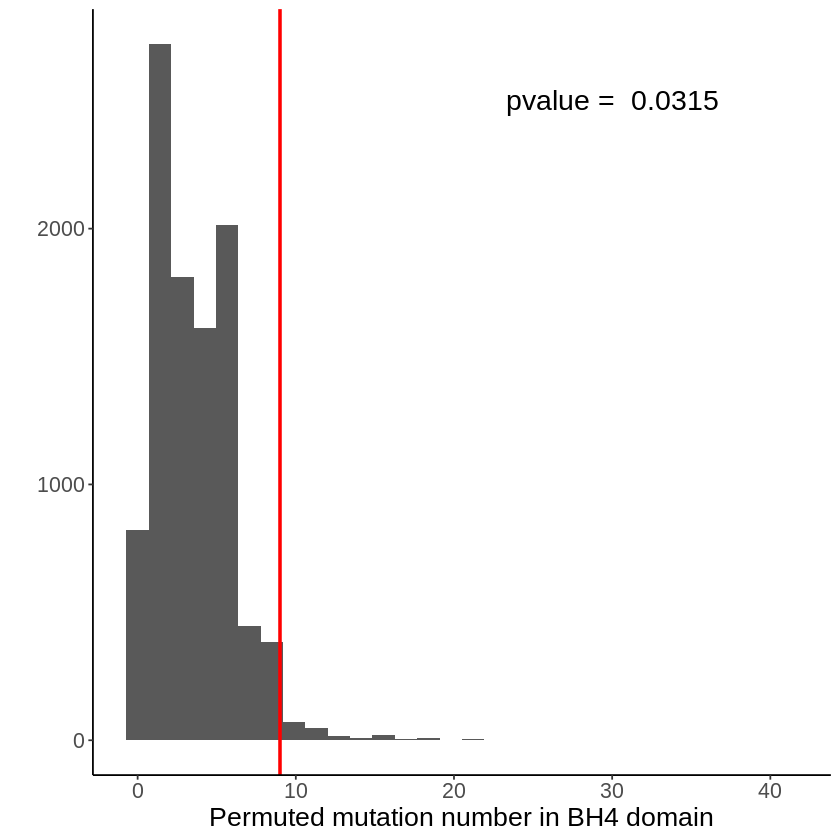

In [32]:
sp = qplot(bh4.per.nmut, geom="histogram", bins = 30,xlab = "Permuted mutation number in BH4 domain")
sp   + 
  geom_vline(xintercept = bh4.obs.nmut, color = "red", size=1) + 
  annotate(geom="text",x=30, y= 2500,label=paste('pvalue = ',bh4.pval),color="black", size = 6)+
  theme_classic()+theme(text=element_text(size=16))
ggsave(file.path(dir.fig.out, 'fig5_bh4_hist.pdf'), height = 3 , width = 5)

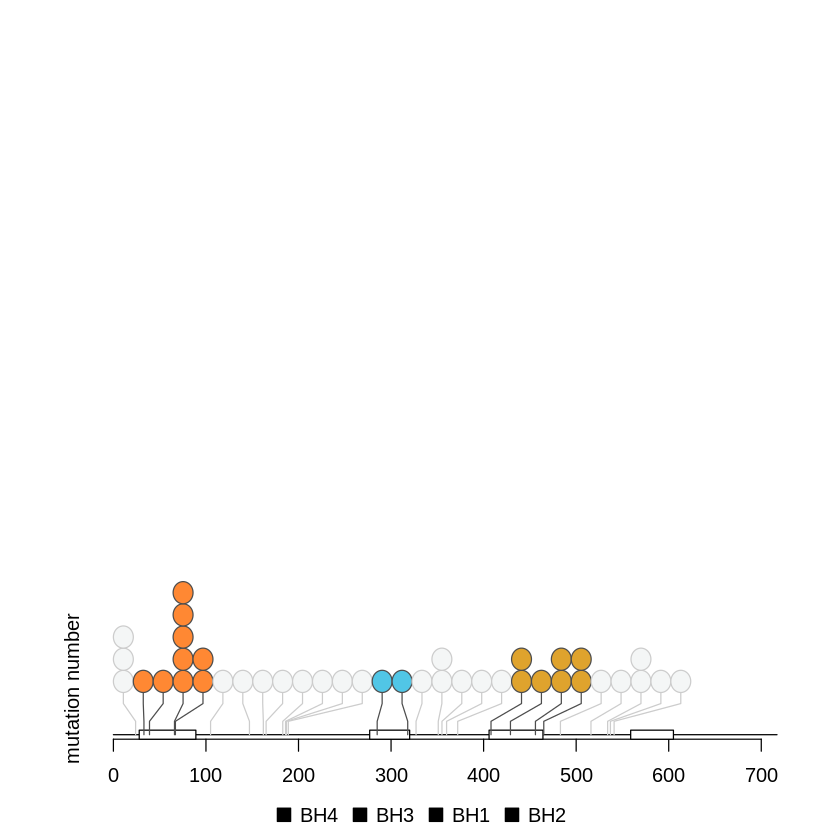

In [21]:
#------------------------------------------------------
# For lollipop plot
#------
# Get mutation positions
muts = which(arr.bcl2!=0)
n.mut = c()
for(i in which(arr.bcl2!=0)){
  n.mut = c(n.mut,arr.bcl2[i])
}
sample.gr <- GRanges("BCL-2 cDNA", IRanges(muts, width=1))
sample.gr$score <- n.mut
features <- GRanges("BCL-2 cDNA", IRanges(c(28, 277, 406,559), 
                                          width=c(62, 44, 59,47),
                                          names=c('BH4','BH3','BH1','BH2')))
# get number of mutations in each domain
n4=0;n3=0;n1=0;n2=0;na = 0;nb=0;nc=0;nd=0;ne = 0
for(i in muts){
  if(i<BH4[1]){
    na = na+1
  }
  if(i<=BH4[2] &&i>=BH4[1]){
    n4 = n4+1
  }
  if(i>BH4[2] && i< BH3[1]){
    nb = nb+1
  }
  if(i<=BH3[2] &&i>=BH3[1]){
    n3 = n3+1
  }
  if(i<BH1[1] &&i>BH3[2]){
    nc = nc+1
  }
  if(i<=BH1[2] &&i>=BH1[1]){
    n1 = n1+1
  }
  if(i<BH2[1] &&i>BH1[2]){
    nd = nd+1
  }
  if(i<=BH1[2] &&i>=BH2[1]){
    n2 = n2+1
  }
  if(i>BH2[2]){
    ne = ne+1
  }
}

mut.color = c(rep("#F4F6F6",na),rep("#FF8833",n4),
              rep("#F4F6F6",nb),rep("#51C6E6",n3),
              rep("#F4F6F6",nc),rep("#DFA32D",n1),
              rep("#F4F6F6",nd),rep("#DFA32D",n2),
              rep("#F4F6F6",ne))
borders = c(rep("gray80",na),rep("gray30",n4),
            rep("gray80",nb),rep("gray30",n3),
            rep("gray80",nc),rep("gray30",n1),
            rep("gray80",nd),rep("gray30",n2),
            rep("gray80",ne))

sample.gr$color = mut.color
sample.gr$border = borders

In [27]:
pdf(file=file.path(dir.fig.out, 'fig5_lollipop.pdf'), width = 8, height = 3)
lolliplot(sample.gr,features, 
          ranges = GRanges("BCL-2 cDNA", IRanges(0, length(bcl2.seq))),
          ylab="mutation number", yaxis = F)
dev.off()

png 
  2